# STM Transit Delay Data Preprocessing

This notebook preprocesses data about STM trip updates and weather data in order to build a tree-based regression model that predicts delays in seconds.

## Data Description

`trip_id` unique identifier of a trip<br>
`vehicle_id` unique identifier of a vehicle<br>
`occupancy_status` degree of passenger occupancy<br>
`route_id` bus or metro line<br>
`stop_id` stop number<br>
`stop_lat`stop latitude<br>
`stop_lon`stop longitude<br>
`stop_sequence` sequence of the stop, for ordering<br>
`trip_progress` how far along the trip is the bys from 0 to 1<br>
`wheelchair_boarding` indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false<br>
`realtime_arrival_time` actual arrival time, in milliseconds<br>
`scheduled_arrival_time` planned arrival time, in milliseconds<br>
`temperature` air temperature at 2 meters above ground, in Celsius<br>
`precipitation` total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters<br>
`windspeed` wind speed at 10 meters above ground, in km/h<br>
`weathercode` World Meteorological Organization (WMO) code<br>
`incident_nearby`indicates if an incident happened within 500 meters when the vehicle arrived at the stop

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import LabelEncoder
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import INCIDENT_CATEGORIES, LOCAL_TIMEZONE, WEATHER_CODES

In [3]:
# Load data
df = pd.read_csv('../data/stm_weather_traffic_merged.csv')

## Calculate Delay

In [4]:
# Convert real and scheduled timestamps
df['realtime_arrival_time'] = pd.to_datetime(df['realtime_arrival_time'], origin='unix', unit='ms', utc=True)
df['scheduled_arrival_time'] = pd.to_datetime(df['scheduled_arrival_time'], origin='unix', unit='ms', utc=True)

In [5]:
# Calculate delay in seconds (real - scheduled)
df['delay'] = (df['realtime_arrival_time'] - df['scheduled_arrival_time']).dt.total_seconds()

## Small EDA

In [6]:
# Get correlations of features with delay
correlations = df.corr().iloc[:-1]['delay']
correlations.sort_values(key=abs, ascending=False)

stop_sequence             0.090699
trip_progress             0.072850
occupancy_status          0.055537
route_id                  0.025745
realtime_arrival_time     0.018650
stop_lat                  0.016695
stop_lon                  0.015605
scheduled_arrival_time    0.012987
windspeed                -0.011292
incident_nearby          -0.008974
weathercode               0.008614
temperature              -0.006508
wheelchair_boarding       0.005761
vehicle_id                0.005323
stop_id                  -0.004454
precipitation             0.001580
Name: delay, dtype: float64

In [7]:
# Get distribution of delays
df['delay'].describe()

count    74055.000000
mean        56.774884
std        256.492136
min      -8222.000000
25%          0.000000
50%          0.000000
75%         62.000000
max      21634.000000
Name: delay, dtype: float64

In [8]:
# Get proportion of trips that are on time
on_time_mask = df['delay'] == 0
print(f'{(on_time_mask.sum() / len(df)):.2%}')

64.45%


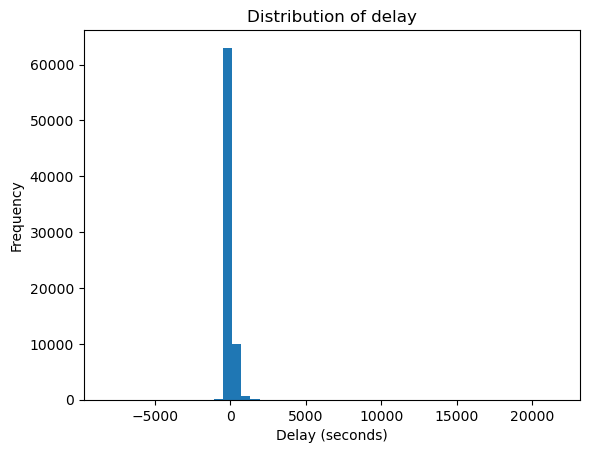

In [9]:
# Plot distribution of delay
plt.hist(df['delay'], bins=50)
plt.title('Distribution of delay')
plt.xlabel('Delay (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_hist.png', bbox_inches='tight')
plt.show()

The plot shows there are some massive delays (~2h15min early to ~5h15min late), which could greatly affect the model performance.

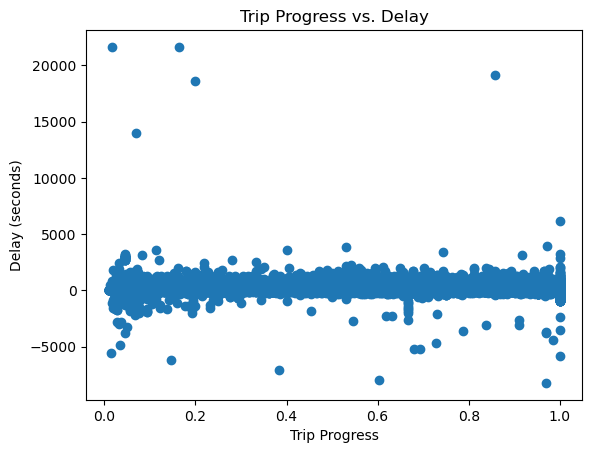

In [10]:
# Plot trip progress vs. delay
plt.scatter(x=df['trip_progress'], y=df['delay'])
plt.title('Trip Progress vs. Delay')
plt.xlabel('Trip Progress')
plt.ylabel('Delay (seconds)')
plt.savefig('../images/trip_progress_vs_delay.png', bbox_inches='tight')
plt.show()

From the plot, it looks like the delay is relatively stable across the trip progress. There are many data points that appear scattered around the x-axis, indicating that delays do not change significantly throughout the trip in many cases. The wide range of delays suggests that delays are highly variable, but there is not clear relationship between trip progress and delay. This could imply that other factors like traffic, accidents, mechanical issues or weather may have more impact on the delays.

## Data Preprocessing

### Handle Outliers

In [11]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [12]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [14]:
# Get outliers
df[outlier_mask]

,vehicle_id,occupancy_status,route_id,stop_id,stop_lat,stop_lon,stop_sequence,trip_progress,wheelchair_boarding,realtime_arrival_time,scheduled_arrival_time,temperature,precipitation,windspeed,weathercode,incident_nearby,delay
97,30214,1,30,51335,45.540641,-73.612946,25,0.555556,1,2025-04-27 22:15:52+00:00,2025-04-27 21:58:48+00:00,11.1,0.0,10.9,0,0.0,1024.0
98,30214,1,30,54127,45.556117,-73.667282,45,1.000000,1,2025-04-27 22:32:04+00:00,2025-04-27 22:15:00+00:00,10.0,0.0,12.9,0,0.0,1024.0
151,38066,1,201,57772,45.441143,-73.814974,52,0.776119,1,2025-04-27 22:12:21+00:00,2025-04-27 21:58:04+00:00,11.1,0.0,10.9,0,0.0,857.0
217,30256,1,189,53754,45.596932,-73.535748,1,0.015625,1,2025-04-27 22:28:10+00:00,2025-04-27 22:14:00+00:00,11.1,0.0,10.9,0,0.0,850.0
289,37067,1,124,50691,45.496493,-73.642564,20,0.487805,1,2025-04-27 22:45:04+00:00,2025-04-27 22:15:10+00:00,10.0,0.0,12.9,0,0.0,1794.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73918,39064,1,822,62138,45.589525,-73.537341,1,0.071429,1,2025-04-29 21:07:00+00:00,2025-04-29 20:40:00+00:00,18.5,0.2,12.7,51,0.0,1620.0
73937,36023,2,33,55298,45.614571,-73.612286,11,0.183333,1,2025-04-29 20:59:23+00:00,2025-04-29 21:22:50+00:00,18.5,0.2,12.7,51,0.0,-1407.0
74007,38013,2,811,62138,45.589525,-73.537341,1,0.045455,1,2025-04-29 22:00:00+00:00,2025-04-29 21:11:00+00:00,17.6,3.2,16.7,63,0.0,2940.0
74015,30143,3,968,61988,45.510414,-73.811740,3,1.000000,1,2025-04-29 21:11:59+00:00,2025-04-29 21:27:00+00:00,18.5,0.2,12.7,51,0.0,-901.0


In [15]:
# Get proportion of outliers
print(f'{outlier_mask.mean():.2%}')

1.01%


In [16]:
# Remove outliers
df = df[~outlier_mask]

In [17]:
# Get new distribution
df['delay'].describe()

count    73304.000000
mean        49.046369
std        125.774439
min       -705.000000
25%          0.000000
50%          0.000000
75%         54.000000
max        826.000000
Name: delay, dtype: float64

The delay ranging from ~16 min early to 18min45sec seems more reasonable.

In [18]:
df.columns

Index(['vehicle_id', 'occupancy_status', 'route_id', 'stop_id', 'stop_lat',
       'stop_lon', 'stop_sequence', 'trip_progress', 'wheelchair_boarding',
       'realtime_arrival_time', 'scheduled_arrival_time', 'temperature',
       'precipitation', 'windspeed', 'weathercode', 'incident_nearby',
       'delay'],
      dtype='object')

### Encode Datetime

In [19]:
# Convert arrival times to local timezone
df['realtime_arrival_time'] = df['realtime_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)
df['scheduled_arrival_time'] = df['scheduled_arrival_time'].dt.tz_convert(LOCAL_TIMEZONE)

In [20]:
# Convert datetimes to day and hour
df['day'] = df['realtime_arrival_time'].dt.day_of_week
df['hour'] = df['realtime_arrival_time'].dt.hour

df['sch_day'] = df['scheduled_arrival_time'].dt.day_of_week
df['sch_hour'] = df['scheduled_arrival_time'].dt.hour

In [21]:
# Use Cyclical Encoding for day and hour, as it's more suitable for time-related features
# And the model can "understand" the wrap-around
df['day_sin'] = np.sin(2 * np.pi * df['day'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day'] / 7)

df['sch_day_sin'] = np.sin(2 * np.pi * df['sch_day'] / 7)
df['sch_day_cos'] = np.cos(2 * np.pi * df['sch_day'] / 7)

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['sch_hour_sin'] = np.sin(2 * np.pi * df['sch_hour'] / 24)
df['sch_hour_cos'] = np.cos(2 * np.pi * df['sch_hour'] / 24)

In [22]:
# Add boolean value is_weekend
weekend_mask = df['day'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [23]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

### Use Label Encoding for vehicle_id, route_id and stop_id

In [24]:
le_vehicle = LabelEncoder()
df['vehicle_id'] = le_vehicle.fit_transform(df['vehicle_id'])

In [25]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [26]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Convert weathercode to Categories

In [27]:
# Create weather code mapping
weathercodes = df['weathercode'].sort_values().unique()
condition_list = []
label_list = []

for code in weathercodes:
  condition_list.append(df['weathercode'] == code)
  label_list.append(WEATHER_CODES[code])

In [28]:
# Create categories
df['weather'] = np.select(condition_list, label_list, default='Unknown')

In [29]:
df['weather'].value_counts()

weather
Clear sky        41428
Overcast         11749
Partly cloudy     6684
Mainly clear      5817
Light drizzle     4729
Moderate rain     2897
Name: count, dtype: int64

In [30]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['weather'], drop_first=True, dtype='int64', prefix='weather')
df = df.join(one_hot)

### Convert incident_category to Categories 

## Export Data

In [31]:
df.columns

Index(['vehicle_id', 'occupancy_status', 'route_id', 'stop_id', 'stop_lat',
       'stop_lon', 'stop_sequence', 'trip_progress', 'wheelchair_boarding',
       'realtime_arrival_time', 'scheduled_arrival_time', 'temperature',
       'precipitation', 'windspeed', 'weathercode', 'incident_nearby', 'delay',
       'day', 'hour', 'sch_day', 'sch_hour', 'day_sin', 'day_cos',
       'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 'sch_hour_sin',
       'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'weather',
       'weather_Light drizzle', 'weather_Mainly clear',
       'weather_Moderate rain', 'weather_Overcast', 'weather_Partly cloudy'],
      dtype='object')

In [34]:
# Keep encoded columns and reorder them
df = df[[
	'vehicle_id',
  	'occupancy_status',
  	'route_id', 
  	'stop_id',
  	'stop_lat',
  	'stop_lon',
	'stop_sequence',
  	'trip_progress',
	'wheelchair_boarding',
  	'day_sin',
  	'day_cos',
  	'sch_day_sin',
  	'sch_day_cos',
  	'hour_sin',
  	'hour_cos', 
	'sch_hour_sin',
  	'sch_hour_cos',
  	'is_weekend',
  	'is_peak_hour', 
	'temperature', 
	'precipitation', 
	'windspeed', 
  	'weather_Light drizzle',
  	'weather_Mainly clear',
    'weather_Moderate rain',
  	'weather_Overcast',
  	'weather_Partly cloudy',
  	'delay'
]]

In [32]:
# Export encoders
encoders = {
	'le_vehicle': le_vehicle,
  	'le_route': le_route,
  	'le_stop': le_stop,
}

with open('../models/label_encoders.pkl', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73304 entries, 0 to 74054
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vehicle_id             73304 non-null  int64  
 1   occupancy_status       73304 non-null  int64  
 2   route_id               73304 non-null  int64  
 3   stop_id                73304 non-null  int64  
 4   stop_lat               73304 non-null  float64
 5   stop_lon               73304 non-null  float64
 6   stop_sequence          73304 non-null  int64  
 7   trip_progress          73304 non-null  float64
 8   wheelchair_boarding    73304 non-null  int64  
 9   day_sin                73304 non-null  float64
 10  day_cos                73304 non-null  float64
 11  sch_day_sin            73304 non-null  float64
 12  sch_day_cos            73304 non-null  float64
 13  hour_sin               73304 non-null  float64
 14  hour_cos               73304 non-null  float64
 15  sch_hou

In [36]:
# Export dataframe
df.to_csv('../data/preprocessed.csv', index=False)

## End